**Восстановление смеси плотностей распределений.**

алгоритм EM (базовый) с фиксированным количеством компонент смеси

Евгений Борисов <esborisov@sevsu.ru>

---

## библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##  загружаем данные 

In [2]:
from sklearn.datasets import make_blobs

n_comp = 4 # количество компонент

X, _ = make_blobs(n_samples=500, centers=n_comp, n_features=2)
display(X.shape)

(500, 2)

In [3]:
# from sklearn.preprocessing import StandardScaler
# X = StandardScaler().fit_transform(X)

## инициализация параметров

In [4]:
from sklearn.cluster import KMeans

mu = KMeans(n_clusters=n_comp, max_iter=10).fit(X).cluster_centers_
display( mu.shape )

(4, 2)

In [5]:
# # мат.ожидания для компонент смеси
# mu = np.mean(X,axis=0) 
# mu = [mu]+[ np.random.normal(loc=mu, scale=1.5, size=mu.shape) for i in range(1,n_comp) ]

# x_max = np.max(X,axis=0)
# mu = [ np.mean(X,axis=0) ] + [ np.random.rand(X.shape[1])*x_max  for i in range(1,n_comp) ]

In [6]:
# матрицы ковариаций признаков для каждой компоненты смеси
S = [ np.cov(X.T) ] * n_comp
# S = [ S for i in range(n_comp) ]

# начальные веса компонент (априорная вероятность)
w = np.ones(n_comp) / n_comp 

### рисуем данные


In [7]:
def plot_mix( S, mu, b=2.0):
    # рисуем мат.ожидание
    mu_ = np.vstack(mu)
    plt.scatter( mu_[:,0], mu_[:,1],s=30,alpha=0.7)

    # рисуем проекцию гауссианы
    a = np.linspace(0.0,2.0,20)*np.pi 
    c = np.array([ np.cos(a), np.sin(a) ])
    
    for j in range(len(S)):
        s = 1.0/( 2.0*np.pi*np.sqrt( np.linalg.det(S[j]) ) ) * b
        #  собственные значения и векторы матрицы ковариаций для компоненты смеси j
        v, l = np.linalg.eig(S[j])  
        v = v*l.sum(axis=1)
        el = c * v.reshape(2,1) * s + mu[j].reshape(2,1)
        plt.plot( el[0,:] , el[1,:]  ) 

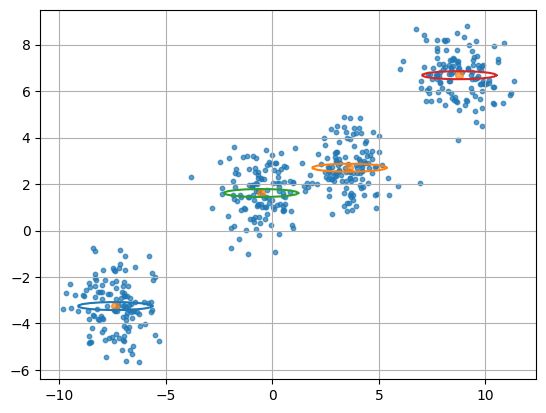

In [8]:
# рисуем начальное состояние
# plt.xlim([-4,+4])
# plt.ylim([-3,+3])
plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7)
plot_mix(S,mu,b=5.0)
plt.grid()
plt.show()

In [9]:
# plt.scatter(  X[:,0],  X[:,1], s=5,  c='b', alpha=0.7)
# plt.scatter( mu[:,0], mu[:,1], s=10, c='r', alpha=0.7)

## оптимизация параметров

фунция n-мерной нормальной плотности распределения
$$
\varphi(x;\theta)
=\mathcal{N}(x;\Sigma,\mu)
=\frac{ \exp\left( -\frac{1}{2}(x-\mu)^T \cdot \Sigma^{-1} \cdot (x-\mu) \right)  }
      { \sqrt{ (2\pi)^n \det \Sigma } }
$$

In [10]:
# фунция n-мерной нормальной плотности распределения
def dens_gauss(X,iS,dS,mu):
    n = X.shape[1] # размерность пространства
    s = 1.0 / np.sqrt( dS * np.square(2.0*np.pi)  )
    Xm = X - mu
    return s*np.exp( -0.5 * (Xm.dot(iS)*Xm).sum(axis=1) )
    

оценка параметров

$$
g_{ij} = \frac{ w_j \cdot \mathcal{N}(x_i;\Sigma_j,\mu_j) }
              { \sum\limits_k w_k \cdot \mathcal{N}(x_i;\Sigma_k,\mu_k) }
$$



In [11]:
# оценка параметров
def e_step( X, S, mu, w ):
    n_comp = len(w)
    m = X.shape[0] # количество учебных примеров
   
    # для для каждой компоненты смеси вычисляем ...
    # обратные матрицы ковариаций признаков 
    iS = [ np.linalg.inv(si)  for si in S ] 
    # определители матрицы ковариаций признаков 
    dS = [ np.linalg.det(si)  for si in S ] 
    
    # взвешеное значение плотности распределения для каждой точки по всем компоненитам смеси
    p = np.vstack([ dens_gauss(X,iS[j],dS[j],mu[j]) * w[j] for j in range(n_comp)] )
    
    return p/p.sum(axis=0)


изменение параметров

$$
w_j = \frac{1}{m}\sum\limits_{i=1}^{m} g_{ij}
$$

$$
N_j = \sum\limits_{i=1}^{m} g_{ij}\ \ ;\ \ \
\mu_j = \frac{1}{ N_j } \sum\limits_{i=1}^{m} g_{ij} \cdot x_i
$$

$$
\Sigma_j = \frac{1}{ c\cdot N_j} 
                \cdot \sum\limits_i g_{ij}(x_i-\mu_j)^T(x_i-\mu_j)\ \ \ ; \ \ 
0 < c \leq 1
$$


In [12]:
# оптимизация параметров
def m_step(X,g,G_FACTOR=0.22):
    n_comp = g.shape[0]
    
    sg = g.sum(axis=1)
    
    w = sg/X.shape[0]   # веса компонент смеси
    
    # мат.ожидания для компонент смеси
    mu = [ ( g[j,:].reshape(X.shape[0],1) * X ).sum(axis=0) / sg[j] for j in range(n_comp) ]

    # изменяем матрицы ковариаций 
    Xm = [ ( X-mu[j] ) * g[j].reshape(X.shape[0],1) for j in range(n_comp) ]
    S = [ Xm[j].T.dot(Xm[j]) / ( sg[j]*G_FACTOR ) for j in range(n_comp)  ]   
    
    return S, mu, w
    

In [13]:
# EM базовый 
MAX_ITER = 500 # максимальное количество циклов
G_MAX = 1e-4 # минимальное изменение оценки (критерий остановки EM)

# начальные значения оценок
g = np.zeros( [ n_comp, X.shape[0],  ]  ) 

for i in range(MAX_ITER):
    g0 = g # сохраняем старую оценку параметров
    g = e_step(X,S,mu,w) # оценка параметров
    S, mu, w = m_step(X,g) # оптимизация параметров

    # считаем изменение оценки
    gm = np.abs( g - g0 ).max() 

    assert ~np.isnan(gm), 'ошибка вычислений, неудачные начальные параметры'

    print("%i: %f/%f"%(i,gm,G_MAX))

    #  проверяем условия завершения работы
    if( gm < G_MAX ): break # изменение оценки ниже порога, конец работы


0: 0.805691/0.000100
1: 0.218385/0.000100
2: 0.222664/0.000100
3: 0.159584/0.000100
4: 0.120962/0.000100
5: 0.105394/0.000100
6: 0.151327/0.000100
7: 0.303254/0.000100
8: 0.361546/0.000100
9: 0.160290/0.000100
10: 0.079587/0.000100
11: 0.091912/0.000100
12: 0.098051/0.000100
13: 0.117179/0.000100
14: 0.140484/0.000100
15: 0.158856/0.000100
16: 0.140549/0.000100
17: 0.162306/0.000100
18: 0.155722/0.000100
19: 0.130887/0.000100
20: 0.148558/0.000100
21: 0.084454/0.000100
22: 0.084946/0.000100
23: 0.062743/0.000100
24: 0.036981/0.000100
25: 0.018159/0.000100
26: 0.012543/0.000100
27: 0.011716/0.000100
28: 0.010534/0.000100
29: 0.009050/0.000100
30: 0.007499/0.000100
31: 0.006063/0.000100
32: 0.004866/0.000100
33: 0.003932/0.000100
34: 0.003157/0.000100
35: 0.002535/0.000100
36: 0.002040/0.000100
37: 0.001647/0.000100
38: 0.001331/0.000100
39: 0.001069/0.000100
40: 0.000855/0.000100
41: 0.000683/0.000100
42: 0.000543/0.000100
43: 0.000431/0.000100
44: 0.000342/0.000100
45: 0.000271/0.00010

## рисуем результат

In [14]:
# для для каждой компоненты смеси вычисляем ...

# обратные матрицы ковариаций признаков 
iS = [ np.linalg.inv(si)  for si in S ] 
# определители матрицы ковариаций признаков 
dS = [ np.linalg.det(si)  for si in S ] 
# значение плотности для каждой точки набора
p = np.vstack([ dens_gauss(X,iS[i],dS[i],mu[i]) for i in range(len(w)) ])

# номера компонент с максимальным значением плотности для каждой точки набора
pc = np.argmax(p,axis=0)

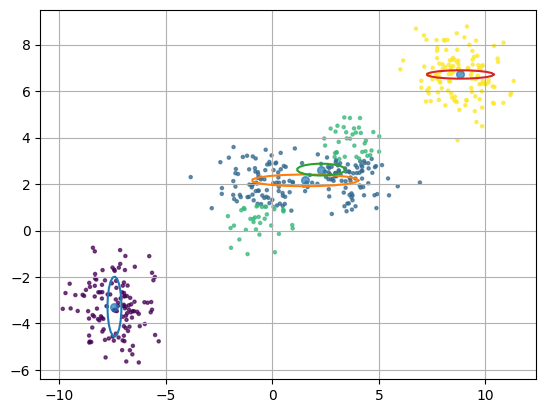

In [15]:
# plt.xlim([-4,+4])
# plt.ylim([-3,+3])
# c = [ ['b','r','g','c'][j] for j in pc  ]
plt.scatter( X[:,0], X[:,1],s=5,alpha=0.7,c=pc)
plot_mix(S,mu,b=5.0)
plt.grid()
plt.show()